In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [1]:
# import the libraries as shown below
import tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
import sklearn
from sklearn.metrics import confusion_matrix, classification_report

In [9]:

# rescales the images between 0 and 1
trained_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


In [2]:
image_shape = (224,224,3)



In [3]:
resnet = ResNet50(input_shape=image_shape, weights='imagenet', include_top=False)

In [4]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [5]:
x = Flatten()(resnet.output)

In [6]:
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [7]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
batch_size = 32
img_height = 224
img_width = 224

In [11]:
train_ds = trained_datagen.flow_from_directory(
  'archive/Training',  # path for train_data

  seed=123,
  target_size=(img_height, img_width),  # Use target_size instead of image_size
  batch_size=batch_size,
)


Found 5712 images belonging to 4 classes.


In [12]:
test_ds = test_datagen.flow_from_directory(
  'archive/Testing',  # path for train_data

  seed=123,
  target_size=(img_height, img_width),  # Use target_size instead of image_size
  batch_size=batch_size,
  shuffle=False  
)

Found 1311 images belonging to 4 classes.


In [14]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel_1.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [19]:
r = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=30,
  steps_per_epoch=len(train_ds),
  validation_steps=len(test_ds),
  callbacks=[checkpoint_cb,earlystop_cb,reduce_lr]
)

Epoch 1/30


2024-04-05 05:31:29.565841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


179/179 [==============================] - 285s 2s/step - loss: 0.6529 - accuracy: 0.7560 - val_loss: 0.9611 - val_accuracy: 0.6476 - lr: 0.0010
Epoch 2/30
179/179 [==============================] - 299s 2s/step - loss: 0.7789 - accuracy: 0.7600 - val_loss: 0.6180 - val_accuracy: 0.8070 - lr: 0.0010
Epoch 3/30
179/179 [==============================] - 299s 2s/step - loss: 0.5104 - accuracy: 0.8132 - val_loss: 0.8941 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 4/30
179/179 [==============================] - 299s 2s/step - loss: 0.6242 - accuracy: 0.7950 - val_loss: 0.4800 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 5/30
179/179 [==============================] - 308s 2s/step - loss: 0.5858 - accuracy: 0.8125 - val_loss: 0.6627 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 6/30
179/179 [==============================] - 308s 2s/step - loss: 0.4690 - accuracy: 0.8342 - val_loss: 0.6016 - val_accuracy: 0.8055 - lr: 0.0010
Epoch 7/30
179/179 [==============================] - 306s 2s/step - loss: 

In [20]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()


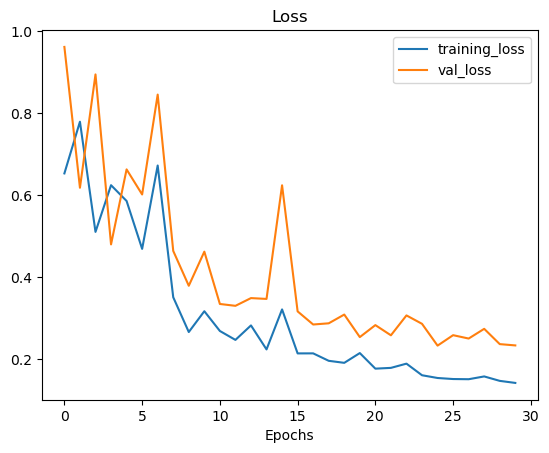

In [21]:
plot_loss_curves(r)

In [26]:
model.save('r3.h5')

In [29]:
loaded_model=keras.models.load_model('r3.h5')

In [30]:
loaded_model.evaluate(test_ds)

2024-04-05 10:55:04.439626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 43s 1s/step - loss: 0.2589 - accuracy: 0.8993


[0.25894036889076233, 0.8993135094642639]

In [32]:
preds=loaded_model.predict(test_ds)

2024-04-05 10:57:20.819265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 47s 1s/step


In [33]:
y_preds=np.argmax(preds,axis=1)

In [34]:
len(y_preds)

1311

In [37]:
import sklearn

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
class_names = test_ds.class_indices

In [25]:
class_names

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [26]:
test_ds.labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [33]:
len(y_pred)

1311

In [50]:
import seaborn as sns
import itertools

In [46]:
print(confusion_matrix(test_ds.labels,y_preds))

[[257  36   2   5]
 [ 47 225   8  26]
 [  3   0 400   2]
 [  2   1   0 297]]


In [51]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

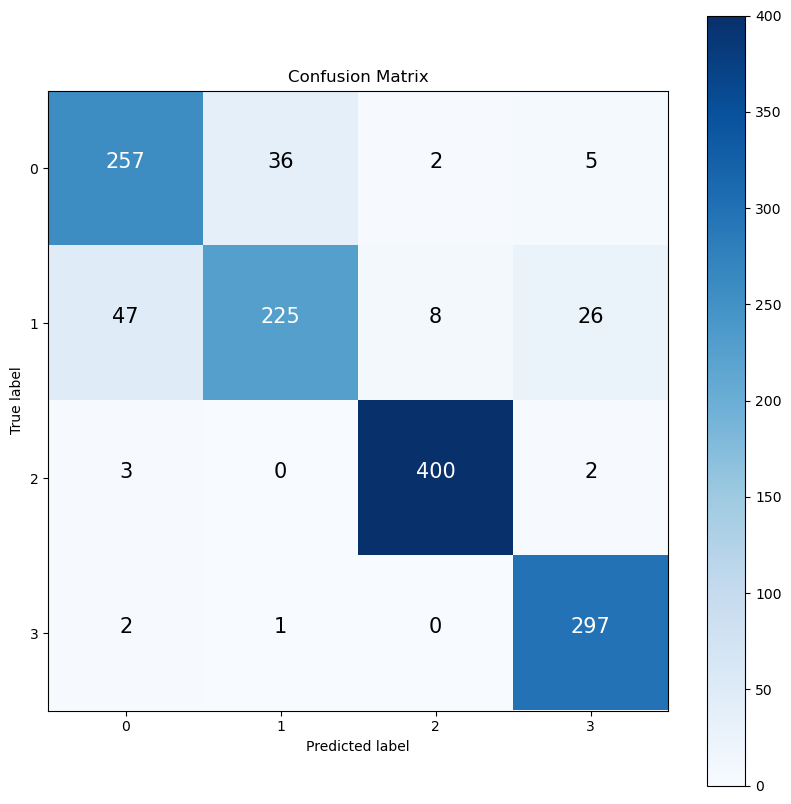

In [52]:
make_confusion_matrix(test_ds.labels,y_preds,savefig=True)

In [47]:

  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  


In [53]:
print(classification_report(test_ds.labels,y_preds))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       300
           1       0.86      0.74      0.79       306
           2       0.98      0.99      0.98       405
           3       0.90      0.99      0.94       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311



In [54]:
class_names =['glioma' , 'meningioma', 'notumor ', 'pituitary']

In [56]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [57]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class

  pred_class = class_names[pred.flatten().argmax()] # if more than one output, take the max

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 69ms/step


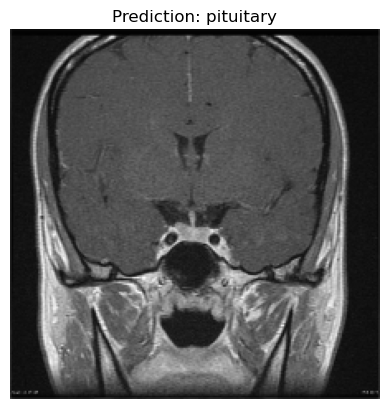

In [62]:
pred_and_plot(loaded_model,'archive/Testing/2.jpeg',class_names)